In [1]:
import nltk
#nltk.download('vader_lexicon')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cleaning: Remove NA and duplicated text

In [190]:
df = pd.read_csv("financialindependence2020.2-2021.csv")
df1=df[['selftext','num_comments','score','title']]

In [191]:
df1=df1.dropna(subset=['selftext'])

#drop meaningless text
df1=df1[(df1.selftext!='[removed]') & (df1.selftext!='[deleted]')]
#df1=df1[(df1.selftext!=' [ ') & (df1.selftext!=' ')]

#drop duplicate
df1=df1.drop_duplicates(subset=['selftext']).reset_index()
df1

,index,selftext,num_comments,score,title
0,0,"Posted this on Personal Finance also, sorry if...",2,1,Velocity Banking
1,1,"Guys, what do you think about the following pr...",1,1,Improving your financial position through Guap...
2,2,"There is so much information, but I am not sur...",5,1,"I am a 19 year old student, what should I focu..."
3,4,Self-promotion (ie posting about projects/busi...,45,1,"Weekly Self-Promotion Thread - May 20, 2020"
4,5,Please use this thread to have discussions whi...,490,1,"Daily FI discussion thread - May 20, 2020"
...,...,...,...,...,...
485,990,My current company offers a very easy mega-bac...,4,1,How helpful is a mega-backdoor roth for financ...
486,992,I have never done anything financial in my lif...,7,1,Extreme Newbie Seeking Guidance/Referrals
487,994,\n\nPlease use this thread to discuss how am...,404,1,"Weekly FI Frugal Friday thread - January 29, 2021"
488,997,I’d love your opinions and feedback on this. I...,0,1,Pay off student loans or wait...?


In [192]:
import re
def remove_other(x):
    x = re.sub("\$"," ", x) #remove $
    x = re.sub("https*\S+", " ", x) #remove url
    x = re.sub("\n",'', x)#remove newlines
    x = re.sub("\*",'',x)
    return x

In [193]:
df1['selftext']=df1['selftext'].apply(lambda x: remove_other(x))

In [194]:
#Remove meaningless rows after cleaning
for i in range(len(df1.selftext)):
    if len(df1.selftext[i])<20:
        df1=df1.drop(i,axis=0)

## VADER

In [196]:
#Overwrite the module function
code='''
from nltk.sentiment.vader import *

def polarity_scores(self,text):
            """
            Return a float for sentiment strength based on the input text.
            Positive values are positive valence, negative value are negative
            valence.
            """
            # text, words_and_emoticons, is_cap_diff = self.preprocess(text)
            sentitext = SentiText(text, self.constants.PUNC_LIST,self.constants.REGEX_REMOVE_PUNCTUATION)
            sentiments = []
            words_and_emoticons = sentitext.words_and_emoticons
            for item in words_and_emoticons:
                valence = 0
                i = words_and_emoticons.index(item)
                if (
                    i < len(words_and_emoticons) - 1
                    and item.lower() == "kind"
                    and words_and_emoticons[i + 1].lower() == "of"
                ) or item.lower() in self.constants.BOOSTER_DICT:
                    sentiments.append(valence)
                    continue

                sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

            sentiments = self._but_check(words_and_emoticons, sentiments)
            zip_iterator = zip(words_and_emoticons, sentiments)
            D= dict(zip_iterator)

            return D,self.score_valence(sentiments,text)
'''
file=open('my_module.py','w')
file.write(code)
file.close()

In [226]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import my_module
import importlib
importlib.reload(my_module)

#create a list of dictionaries
sia = SIA()
results = []
words=[]

for line in df1['selftext']:
    #pol_score = sia.polarity_scores(line)
    D,pol_score=my_module.polarity_scores(sia,text=line) #use customized module
    pol_score['selftext'] = line
    results.append(pol_score)
    words.append(D)
results[:3]

[{'neg': 0.061,
  'neu': 0.822,
  'pos': 0.117,
  'compound': 0.9143,
  'selftext': "Posted this on Personal Finance also, sorry if it's a double read for some of you!Alright....I'm sure that this won't be well received but I want to know what people think of 'Velocity Banking' (best video I've seen is titled The Method on YouTube), whether it works or not, scam/not a scam, and then finally how it compares to just taking your monthly surplus and simply putting it into the market.Quick background, 35 yo, own a house (but will be selling within 6 months to move to Japan), wife and 1 child. Only debt we have is the mortgage and our monthly spending (no CC, no car payments). Quick Financials:Checking/Savings-16,000Vanguard IRA/Brokerage-26,000TSP(Combined)-120,000Currently have about  500/mo extra (I'm deployed currently, TSP set at 60%), when I get back I'll scale it back and will have more like  1500-2000/mo free.Feel like we're doing well but would just love to see some conversation for

In [345]:
#Extract sentiment words
D_p=[] # positive word and its sentiment score
D_n=[] # negative word and its sentiment score
D1=[] # only positive word
D2=[] # only negative word
for i in range(len(words)):
    newDict = {key: value for (key, value) in words[i].items() if value != 0.0 }
    newDict1 = {key: value for (key, value) in words[i].items() if value > 0.0 }
    newDict2 = {key: value for (key, value) in words[i].items() if value < 0.0 }
    D_p.append(newDict1)
    D_n.append(newDict2)
    D1.append(list(newDict1.keys()))
    D2.append(list(newDict2.keys()))
print(D_p[0])
print(D_n[0])
print(D1[0])
print(D2[0])

{'sure': 0.65, 'want': 0.44999999999999996, 'scam': 2.997, 'like': 2.6895, 'love': 4.800000000000001}
{'sorry': -0.15, 'well': -1.221, 'debt': -2.25, 'no': -1.7999999999999998}
['sure', 'want', 'scam', 'like', 'love']
['sorry', 'well', 'debt', 'no']


In [346]:
#create a df to write in the results of sentiment analysis
sent = pd.DataFrame(results)
sent['p_word_dict']=D_p
sent['n_word_dict']=D_n
p=[]
n=[]
for i in D1:
    p.append(' '.join(i))
for i in D2:
    n.append(' '.join(i))
    
sent['p_word']=p
sent['n_word']=n
sent

,neg,neu,pos,compound,selftext,p_word_dict,n_word_dict,p_word,n_word
0,0.061,0.822,0.117,0.9143,"Posted this on Personal Finance also, sorry if...","{'sure': 0.65, 'want': 0.44999999999999996, 's...","{'sorry': -0.15, 'well': -1.221, 'debt': -2.25...",sure want scam like love,sorry well debt no
1,0.021,0.761,0.218,0.9901,"Guys, what do you think about the following pr...","{'support': 1.7, 'rewards': 2.1, 'supporting':...","{'exclude': -0.9, 'obstacles': -1.6}",support rewards supporting accept saved create...,exclude obstacles
2,0.120,0.880,0.000,-0.3491,"There is so much information, but I am not sur...",{},{'sure': -1.443},,sure
3,0.090,0.839,0.071,-0.2644,Self-promotion (ie posting about projects/busi...,"{'profit': 1.9, 'Please': 1.3, 'wisely': 1.8}","{'discouraged': -1.7, 'please': -0.962, 'leak'...",profit Please wisely,discouraged please leak banned
4,0.000,0.933,0.067,0.6996,Please use this thread to have discussions whi...,"{'Please': 1.3, 'relaxed': 2.2}",{},Please relaxed,
...,...,...,...,...,...,...,...,...,...
477,0.032,0.741,0.227,0.9663,My current company offers a very easy mega-bac...,"{'easy': 1.0965, 'want': 0.15, 'sure': 1.95000...",{'reject': -2.55},easy want sure helpful better value appreciate...,reject
478,0.077,0.816,0.107,0.6369,I have never done anything financial in my lif...,"{'credit': 1.6, 'interest': 2.0, 'help': 1.7, ...","{'no': -1.2, 'idk': -0.4, 'Sorry': -0.3, 'wron...",credit interest help better,no idk Sorry wrong
479,0.039,0.874,0.087,0.7292,Please use this thread to discuss how amazin...,"{'Please': 1.3, 'pain': 1.702, 'relaxed': 2.49...","{'low': -1.1, 'cut': -1.1}",Please pain relaxed,low cut
480,0.032,0.782,0.186,0.9393,I’d love your opinions and feedback on this. I...,"{'love': 1.6, 'saved': 0.9, 'interest': 3.0, '...",{'pay': -0.6000000000000001},love saved interest Thank,pay


In [348]:
sent['total']=(sent.pos-sent.neg)/sent.neu

In [349]:
#labeling the sentiment of selftext
sent['label']=0
sent['label'].loc[sent['total']> 0]=1
sent['label'].loc[sent['total']< 0]=-1
sent

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,neg,neu,pos,compound,selftext,p_word_dict,n_word_dict,p_word,n_word,label,total
0,0.061,0.822,0.117,0.9143,"Posted this on Personal Finance also, sorry if...","{'sure': 0.65, 'want': 0.44999999999999996, 's...","{'sorry': -0.15, 'well': -1.221, 'debt': -2.25...",sure want scam like love,sorry well debt no,1,0.068127
1,0.021,0.761,0.218,0.9901,"Guys, what do you think about the following pr...","{'support': 1.7, 'rewards': 2.1, 'supporting':...","{'exclude': -0.9, 'obstacles': -1.6}",support rewards supporting accept saved create...,exclude obstacles,1,0.258870
2,0.120,0.880,0.000,-0.3491,"There is so much information, but I am not sur...",{},{'sure': -1.443},,sure,-1,-0.136364
3,0.090,0.839,0.071,-0.2644,Self-promotion (ie posting about projects/busi...,"{'profit': 1.9, 'Please': 1.3, 'wisely': 1.8}","{'discouraged': -1.7, 'please': -0.962, 'leak'...",profit Please wisely,discouraged please leak banned,-1,-0.022646
4,0.000,0.933,0.067,0.6996,Please use this thread to have discussions whi...,"{'Please': 1.3, 'relaxed': 2.2}",{},Please relaxed,,1,0.071811
...,...,...,...,...,...,...,...,...,...,...,...
477,0.032,0.741,0.227,0.9663,My current company offers a very easy mega-bac...,"{'easy': 1.0965, 'want': 0.15, 'sure': 1.95000...",{'reject': -2.55},easy want sure helpful better value appreciate...,reject,1,0.263158
478,0.077,0.816,0.107,0.6369,I have never done anything financial in my lif...,"{'credit': 1.6, 'interest': 2.0, 'help': 1.7, ...","{'no': -1.2, 'idk': -0.4, 'Sorry': -0.3, 'wron...",credit interest help better,no idk Sorry wrong,1,0.036765
479,0.039,0.874,0.087,0.7292,Please use this thread to discuss how amazin...,"{'Please': 1.3, 'pain': 1.702, 'relaxed': 2.49...","{'low': -1.1, 'cut': -1.1}",Please pain relaxed,low cut,1,0.054920
480,0.032,0.782,0.186,0.9393,I’d love your opinions and feedback on this. I...,"{'love': 1.6, 'saved': 0.9, 'interest': 3.0, '...",{'pay': -0.6000000000000001},love saved interest Thank,pay,1,0.196931


In [314]:
#sent.to_csv('sent_FIRE.csv', mode='a', encoding='utf-8', index=False)

## Generate Summary

In [316]:
sent.describe()

,neg,neu,pos,compound,label,total
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,0.053651,0.832114,0.114222,0.465431,0.570539,0.079615
std,0.047085,0.085286,0.075340,0.585348,0.792509,0.135607
min,0.000000,0.472000,0.000000,-0.996900,-1.000000,-0.533742
25%,0.018250,0.784000,0.067000,0.089850,1.000000,0.004682
50%,0.047000,0.838000,0.105000,0.732650,1.000000,0.063924
75%,0.078750,0.887750,0.147750,0.936600,1.000000,0.127647
max,0.348000,1.000000,0.528000,0.999800,1.000000,1.118644


In [419]:
sent[sent.label==0].head(5)

,neg,neu,pos,compound,selftext,p_word_dict,n_word_dict,p_word,n_word,label,total
28,0.0,1.0,0.0,0.0,mixture cash investment graduated year half ag...,{},{},,,0,0.0
48,0.0,1.0,0.0,0.0,federal reserve activity providing backstop am...,{},{},,,0,0.0
75,0.0,1.0,0.0,0.0,stimulus payment allegedly sent starting today...,{},{},,,0,0.0
80,0.0,1.0,0.0,0.0,assuming majority people arent going change in...,{},{},,,0,0.0
123,0.0,1.0,0.0,0.0,talking getting first property comment complet...,{},{},,,0,0.0


(array([ 92.,   0.,   0.,   0.,   0.,  23.,   0.,   0.,   0., 367.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

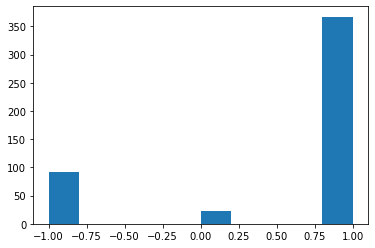

In [408]:
plt.hist(sent.label)

(array([  1.,   4.,  52., 303.,  99.,  13.,   7.,   2.,   0.,   1.]),
 array([-0.53374233, -0.36850369, -0.20326505, -0.03802641,  0.12721223,
         0.29245087,  0.45768951,  0.62292815,  0.78816679,  0.95340543,
         1.11864407]),
 <a list of 10 Patch objects>)

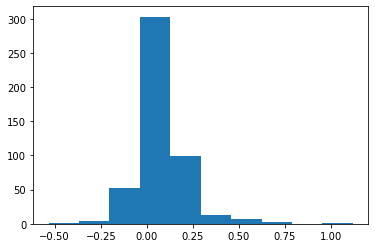

In [407]:
plt.hist(sent.total) #approximatly normal

In [318]:
sent.sort_values(by='total',ascending=False)

,neg,neu,pos,compound,selftext,word_list,word,label,total
338,0.000,0.472,0.528,0.8834,I'm feeling like a pretty good older sister an...,"{'feeling': 0.5, 'like': 1.5, 'pretty': 2.2, '...",feeling like pretty good share,1,1.118644
38,0.000,0.563,0.437,0.7178,For me I will be retiring to a more stable cou...,"{'stable': 1.4929999999999999, 'protects': 1.3...",stable protects freedoms,1,0.776199
436,0.000,0.584,0.416,0.9832,Today I love to share a FREE training that mak...,"{'love': 3.2, 'share': 1.2, 'FREE': 3.033, 'ea...",love share FREE easy profitable credit :),1,0.712329
168,0.000,0.617,0.383,0.6369,Interesting image I want to share with you all...,"{'Interesting': 1.7, 'want': 0.3, 'share': 1.2}",Interesting want share,1,0.620746
197,0.000,0.626,0.374,0.9538,It's very rudimentary - the calculations are b...,"{'welcome': 3.0, 'improve': 2.8499999999999996...",welcome improve like curious,1,0.597444
...,...,...,...,...,...,...,...,...,...
127,0.178,0.822,0.000,-0.3818,My attempt. A documentation of a \~1.5y old f...,{'fight': -1.6},fight,-1,-0.216545
264,0.178,0.822,0.000,-0.9562,"I realize I'm probably misguided, but this is ...","{'wise': -2.331, 'risk': -1.6500000000000001, ...",wise risk like wrong,-1,-0.216545
40,0.182,0.818,0.000,-0.4404,When you have enough money to do almost anythi...,{'worry': -1.9},worry,-1,-0.222494
456,0.207,0.793,0.000,-0.4824,What is you view on investing in the stock ma...,{'FIRE': -2.133},FIRE,-1,-0.261034


In [319]:
sent['selftext'][38]

'For me I will be retiring to a more stable country that protects freedoms.'

## Sentiment Word Contribution

In [367]:
all_words=SIA.make_lex_dict(sia)
all_words['like'] #not perfectly match all_words due to punctuation amplifier

1.5

In [368]:
sent.p_word_dict[sent['label']==1][0]

{'sure': 0.65,
 'want': 0.44999999999999996,
 'scam': 2.997,
 'like': 2.6895,
 'love': 4.800000000000001}

In [381]:
positive=sent.p_word[sent['label']==1] #positive words in positive post
negative=sent.n_word[sent['label']==-1] #negative words in negative post

In [377]:
# List of all words across rows
import itertools
import collections
def count_words(text):
    all_words = list(itertools.chain(*text.str.split()))
    counts = collections.Counter(all_words)
    counts_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])

    return counts_df

In [396]:
p_n=pd.concat([count_words(positive)[:5],count_words(negative)[:5]])
#count_words(positive).head(15)
#count_words(negative).head(15)
p_n

,words,count
0,like,143
1,want,81
2,good,67
3,better,59
4,worth,47
0,FIRE,27
1,pay,21
2,no,19
3,debt,12
4,low,10


In [405]:
import plotly.graph_objects as go

colors = ['lightslategray',] * 5
colors = ['crimson',] * 5

fig = go.Figure(data=[go.Bar(
    x=p_n['words'],
    y=p_n['count'],
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Most common positive and negative sentiment words')

------------------------------------------------------------------------------------------

## Word Frequency splitted by Sentiment

In [360]:
sent['selftext']=sent['selftext'].str.lower()
def remove_emoji(text):
    text = text.encode('ascii', 'ignore').decode()
    return text

sent['selftext']=sent['selftext'].apply(lambda x: remove_emoji(x))

import re
def remove_other(x):
    x = re.sub("\$"," ", x) #remove $
    x = re.sub("https*\S+", " ", x) #remove url
    x = re.sub("\'\w+", '', x) #remove i'm,we're,let's after the '
    x = re.sub("[0-9]+", '', x) #remove numbers
    x = re.sub("\n",'', x)#remove newlines
    return x

sent['selftext']=sent['selftext'].apply(lambda x: remove_other(x))

from nltk.corpus import stopwords
#nltk.download("stopwords") #uncomment it when run it for the first time
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

sent['selftext']=sent['selftext'].apply(lambda x: remove_stopwords(x))

spec_chars = ["!",'“','"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    sent['selftext'] = sent['selftext'].str.replace(char, ' ')
    sent['selftext'] = sent['selftext'].str.split().str.join(" ")
    
from nltk.stem import WordNetLemmatizer

def lemmatize(words):
    lemmatizer = WordNetLemmatizer()
    nwords=[]
    for word in words:
        word=lemmatizer.lemmatize(word)
        nwords.append(word)
    return ' '.join(nwords)

sent['selftext']= sent['selftext'].str.split().apply(lambda x: lemmatize(x))

stop_words.update({'would','k','im','could','also',
                   'amp','much','one','like','get',
                   'since','etc','got','always',
                   'know','thing','really','dont',
                   'find','even','go','time','need','want'
                  })
sent['selftext']=sent['selftext'].apply(lambda x: remove_stopwords(x))

In [427]:
from nltk.util import ngrams
def count_2gram(text):
    all_words = list(itertools.chain(*text.str.split()))
    es2grams = ngrams(all_words, 2)
    counts = collections.Counter(es2grams)
    count_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])
    dictionary2 = [' '.join(tup) for tup in count_df.words]
    count_df.words=dictionary2

    return count_df

count_df2=count_2gram(sent['selftext'][sent['label']==1])
#count_df2=count_2gram(sent['selftext'][sent['total']>0.127])
count_df3=count_2gram(sent['selftext'][sent['label']==-1])
#count_df3=count_2gram(sent['selftext'][sent['total']<0.0046])

#positive word distribution
count_df2.head(10)

,words,count
0,roth ira,59
1,year old,39
2,brokerage account,39
3,index fund,31
4,saving account,29
5,credit card,28
6,net worth,28
7,long term,26
8,next year,26
9,stock market,25


In [428]:
#Negative word distribution
count_df3.head(10)

,words,count
0,emergency fund,28
1,net worth,16
2,roth ira,15
3,next year,12
4,year old,9
5,saving account,9
6,side gig,9
7,ef investor,8
8,year ago,8
9,stock market,7


In [429]:
def count_3gram(text):
    all_words = list(itertools.chain(*text.str.split()))
    es3grams = ngrams(all_words, 3)
    counts = collections.Counter(es3grams)
    count_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])
    dictionary3 = [' '.join(tup) for tup in count_df.words]
    count_df.words=dictionary3

    return count_df


count_df4=count_3gram(sent['selftext'][sent['label']==1])
count_df5=count_3gram(sent['selftext'][sent['label']==-1])

#positive word distribution
count_df4

,words,count
0,expense ratio administrative,20
1,ratio administrative cost,20
2,credit card debt,7
3,please use thread,5
4,rule posting question,5
...,...,...
95,pay credit card,3
96,money left end,3
97,left end v,3
98,student loan paid,3


In [366]:
count_df5

,words,count
0,monthly maintenance fee,6
1,goal emergency fund,4
2,ef net worth,4
3,large enough portfolio,3
4,traditional emergency fund,3
...,...,...
95,r financialindependence post,1
96,financialindependence post removed,1
97,post removed moderation,1
98,removed moderation thread,1


## Average sentiment score of a given word

In [412]:
sent['total'].mean()

0.07961512293328499

In [411]:
index=sent[sent['selftext'].str.contains("roth ira")].index
sent.iloc[index]['total'].mean()

0.0611926782455175

In [413]:
index=sent[sent['selftext'].str.contains("net worth")].index
sent.iloc[index]['total'].mean()

0.07794111813669583

In [414]:
index=sent[sent['selftext'].str.contains("brokerage account")].index
sent.iloc[index]['total'].mean()

0.051764391300869614

In [416]:
index=sent[sent['selftext'].str.contains("emergency fund")].index
sent.iloc[index]['total'].mean()

0.029376189394403816

In [417]:
index=sent[sent['selftext'].str.contains("saving account")].index
sent.iloc[index]['total'].mean()

0.04868162996178929

In [418]:
index=sent[sent['selftext'].str.contains("index fund")].index
sent.iloc[index]['total'].mean()

0.07585286792996988

In [430]:
index=sent[sent['selftext'].str.contains("long term")].index
sent.iloc[index]['total'].mean()

0.06391767509138607

In [431]:
index=sent[sent['selftext'].str.contains("credit card")].index
sent.iloc[index]['total'].mean()

0.10073389526904372

In [433]:
sent.iloc[index].sort_values(by='total',ascending=False)

,neg,neu,pos,compound,selftext,p_word_dict,n_word_dict,p_word,n_word,label,total
430,0.052,0.671,0.277,0.9659,turned start building credit getting credit ca...,"{'want': 0.44999999999999996, 'credit': 2.4000...","{'pay': -0.2, 'FIRE': -3.1995}",want credit good easy advantage Thanks,pay FIRE,1,0.335320
220,0.101,0.607,0.292,0.7650,thought mile transfer airline credit card pay ...,"{'Like': 1.5, 'credit': 1.6, 'advantage': 1.0,...","{'pay': -0.4, 'low': -1.1}",Like credit advantage interest,pay low,1,0.314662
246,0.039,0.789,0.172,0.9901,hello r financialindependence ultimate goal re...,"{'freedom': 3.2, 'credit': 1.6, 'free': 2.3, '...","{'pay': -0.4, 'lower': -1.2, 'no': -1.2, 'debt...",freedom credit free save focused growth like b...,pay lower no debt,1,0.168568
469,0.070,0.736,0.194,0.9998,xb moneyist friendly neighbor decade recently ...,"{'friendly': 1.1, 'friends': 3.150000000000000...","{'struggled': -0.7, 'unemployment': -2.8499999...",friendly friends improve successes fun respect...,struggled unemployment stopped no debt lost co...,1,0.168478
377,0.076,0.743,0.181,0.7609,hospital bill kaiser los angeles point affecti...,"{'credit': 1.6, 'true': 2.25, 'Thank': 1.5}","{'debt': -1.5, 'no': -1.2}",credit true Thank,debt no,1,0.141319
339,0.051,0.786,0.162,0.9403,recently paid deductible medical procedure yay...,"{'credit': 0.8, 'beneficial': 2.84999999999999...","{'pay': -0.2, 'interest': -0.74, 'emergency': ...",credit beneficial advantage like better Thanks,pay interest emergency,1,0.141221
239,0.043,0.805,0.152,0.8957,hanging friend day starbucks bought couple dri...,"{'friends': 1.05, 'good': 0.95, 'friend': 1.1,...","{'missing': -1.7999999999999998, 'liability': ...",friends good friend credit like,missing liability,1,0.135404
194,0.068,0.764,0.167,0.7351,ive tried applying lot different credit card b...,"{'credit': 1.6, 'help': 1.7}","{'denied': -1.9, 'pay': -0.4}",credit help,denied pay,1,0.129581
331,0.082,0.754,0.164,0.9036,sure belongs apology working pay credit card d...,"{'credit': 1.6, 'advantage': 1.0, 'interest': ...","{'sure': -0.962, 'pay': -0.4, 'debt': -1.5}",credit advantage interest Like matter,sure pay debt,1,0.108753
410,0.084,0.754,0.162,0.5920,hi guy usa looking advice invest profit instea...,"{'profit': 0.95, 'want': 0.370625, 'leave': 0....","{'emergency': -0.8, 'debt': -0.75, 'risk': -1....",profit want leave credit interest Thanks,emergency debt risk,1,0.103448


In [434]:
sent.selftext[420]

'hi recently came across blog site looking sustainable withdrawal rate swr proportion equity bond investment argument conventional rule thumb understand e reducing equity bond ratio age effective strategy compared bond tent e shift bond retirement normal quickly shift bond equity retirement ha anyone come across us love community opinion many thanks'

In [435]:
sent.selftext[470]

'past week unusual least financial perspective past month period seen unprecedented market wide crash boom yet nothing quite chaos around gamestop r wsb longtime steadfast fire adherent surprised anguish past week caused equally surprised managed self inflict anguish agog stupid situation though stupidity different sort gme type likely feel point near future given community healthy mix never pick stock type pick stock fun money type curious see many either group feeling sense stupid self inflicted anguish week background wife split across various retirement taxable investment account allocated approximately stock bond neither u ever bought individual stock saving come naturally u index investing late early several month school first job looked checking account swelling something thinking hmmm surely something better money narrow escape financial advisor wanting sell u whole life insurance set path self directed index investing good people sa bfc subforum ever said never bought individu